In [1]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.interpolate import CubicSpline
import warnings

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Read the CSV file
df_wind = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'wind3.csv'))

# drop the columns that are not needed
# df_wind = df_wind.drop(columns=['SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit', 'dtm', 'MIP'])
df_wind = df_wind.drop(columns=['dtm', 'MIP', 'date_diff'])

# drop Wind_MW and rename Wind_MWh_credit to Wind_MW
df_wind = df_wind.drop(columns=['Wind_MW'])
df_wind = df_wind.rename(columns={'Wind_MWh_credit': 'Wind_MW'})

# to datetime
df_wind['reference_time'] = pd.to_datetime(df_wind['reference_time'])
df_wind['valid_time'] = pd.to_datetime(df_wind['valid_time'])

df_latest = df_wind.copy()
# drop everything after Jan 20, 2024
df_latest = df_latest[df_latest['valid_time'] < '2024-01-19']

# calculate the average of the two forecasts and drop the individual forecasts (except WindSpeed^3:100)
df_latest['WindSpeed^3:100_avg'] = (df_latest['WindSpeed^3:100_dwd'] + df_latest['WindSpeed^3:100_ncep']) / 2
df_latest['Temperature_avg'] = (df_latest['Temperature_dwd'] + df_latest['Temperature_ncep']) / 2
df_latest['RelativeHumidity_avg'] = (df_latest['RelativeHumidity_dwd'] + df_latest['RelativeHumidity_ncep']) / 2
df_latest['WindDirection:100_avg'] = (df_latest['WindDirection:100_dwd'] + df_latest['WindDirection:100_ncep']) / 2

df_latest = df_latest.drop(columns=['WindSpeed_dwd', 'WindSpeed_ncep', 'Temperature_dwd', 'Temperature_ncep', 'RelativeHumidity_dwd', 'RelativeHumidity_ncep', 'WindSpeed^3_dwd', 'WindSpeed^3_ncep', 'WindDirection_dwd', 'WindDirection_ncep', 'WindSpeed:100_dwd', 'WindSpeed:100_ncep', 'WindSpeed:100^3_dwd', 'WindSpeed:100^3_ncep', 'WindDirection:100_dwd', 'WindDirection:100_ncep'])

# remove ^3 from the column names
df_latest.columns = [col.replace('^3', '') for col in df_latest.columns]

# i. Calculate Power Forecast based on Physics

## 1. Calculate Air Density

In [3]:
# Constants
R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
R_v = 461.5   # Specific gas constant for water vapor (J/(kg·K))
p = 101325    # Standard atmospheric pressure in Pa

# Assuming df_latest is your original DataFrame and contains 'Temperature_dwd', 'RelativeHumidity_dwd', 'WindSpeed_dwd'
# Convert temperature from Celsius to Kelvin
df_latest['Temperature_K'] = df_latest['Temperature_avg'] + 273.15

# Calculate saturation vapor pressure (using temperature in Celsius), Tetens formula
e_s = 0.61078 * np.exp((17.27 * df_latest['Temperature_avg']) / (df_latest['Temperature_avg'] + 237.3))

# in pa
e_s = 1000 * e_s

# Calculate actual vapor pressure
e = df_latest['RelativeHumidity_avg'] / 100 * e_s

# Calculate air density (ρ) in kg/m³
df_latest['AirDensity'] = (p - e) / (R_d * df_latest['Temperature_K']) + (e / (R_v * df_latest['Temperature_K']))

## 2. Calculate Power based on Density and Wind Speed

In [4]:
def calculate_wind_generation(dataset, rotor_diameter = 154, efficiency = 0.31, limiter = 1, minimum_wind_speed = 3, maximum_wind_speed_for_operation = 25, add_opt = False):
    rotor_area = np.pi * (rotor_diameter / 2) ** 2  # in m²
    
    # turbine requires 3m/s to start rotating
    const_internal_friction_coefficient = 0.5 * 1.240 * rotor_area * 3**3 * efficiency * 174 / 1000000
    maximum_power_per_turbine = 7 # in MW

    # Calculate power output based on wind speed at 100m
    dataset['WindPower:100'] = 0.5 * dataset['AirDensity'] * rotor_area * dataset['WindSpeed:100_avg'] ** 3 * 174 / 1000000
    dataset[f'UsableWindPower{"_opt" if add_opt else ":100"}'] = np.minimum(dataset['WindPower:100'], maximum_power_per_turbine * 174 * limiter / efficiency)
    dataset[f'PowerOutput{"_opt" if add_opt else ""}'] = np.where((dataset['WindSpeed:100_avg'] >= minimum_wind_speed) & (dataset['WindSpeed:100_avg'] <= maximum_wind_speed_for_operation), (dataset['UsableWindPower:100'] * efficiency - const_internal_friction_coefficient) * 0.5, 0)

    return dataset

In [5]:
df_latest = calculate_wind_generation(df_latest)

# Absolute error
print('Mean Absolute error:', np.mean(np.abs(df_latest['Wind_MW'] - df_latest['PowerOutput'])))
# Initialize a list to collect the stats
stats_df = pd.DataFrame({'quantile': [], 'quantile_range': [], 'mean_absolute_error': [], 'mean_error': []})

# Mean absolute error in 10% quantiles
for q in np.arange(0.1, 1.1, 0.1):
    # Filter the DataFrame for each quantile range
    quantile_df = df_latest[(df_latest['Wind_MW'] < df_latest['Wind_MW'].quantile(q)) & (df_latest['Wind_MW'] >= df_latest['Wind_MW'].quantile(q - 0.1))]
    
    # Calculate the statistics
    quantile_stats = {
        'quantile': q,
        'quantile_range': f'{df_latest["Wind_MW"].quantile(q - 0.1):.1f} - {df_latest["Wind_MW"].quantile(q):.1f}',
        'mean_absolute_error': np.mean(np.abs(quantile_df['Wind_MW'] - quantile_df['PowerOutput'])),
        'mean_error': np.mean(quantile_df['Wind_MW'] - quantile_df['PowerOutput']),
    }
    
    # Append to the list
    stats_df.loc[len(stats_df)] = quantile_stats

# Display the DataFrame
stats_df

Mean Absolute error: 62.5292962432648


,quantile,quantile_range,mean_absolute_error,mean_error
0,0.1,0.0 - 9.5,25.503579,-24.309190
1,0.2,9.5 - 46.0,30.900085,-14.837630
2,0.3,46.0 - 99.5,47.231788,-8.444923
3,0.4,99.5 - 171.0,62.904160,0.637809
4,0.5,171.0 - 261.9,83.388379,18.261319
5,0.6,261.9 - 378.3,106.973038,31.448559
6,0.7,378.3 - 501.9,117.798816,38.946631
7,0.8,501.9 - 555.6,82.097447,-1.493629
8,0.9,555.6 - 577.7,46.285710,-9.202600
9,1.0,577.7 - 602.2,22.223176,-3.191692


## 3. Find optimal $\eta$ to update the approximation of the turbine efficiency

In [6]:
errors = {}
for efficiency in np.arange(0.28, 0.35, 0.001):
    for limiter in np.arange(0.9, 1.01, 0.01):
        df_tmp = calculate_wind_generation(df_latest, efficiency=efficiency, limiter=limiter)
        mean_abs_error = np.mean(np.abs(df_tmp['Wind_MW'] - df_tmp['PowerOutput']))
        mean_error = np.mean(df_tmp['Wind_MW'] - df_tmp['PowerOutput'])
        errors[(efficiency.round(3), limiter.round(2))] = [mean_abs_error, mean_error]

In [7]:
# Find the minimum error
min_error = min(errors, key=lambda x: errors[x])
print(f'Minimum mean absolute error: {errors[min_error][0]:.2f} with efficiency={min_error}')
print(f'Mean error: {errors[min_error][1]:.2f}')

Minimum mean absolute error: 57.08 with efficiency=(np.float64(0.337), np.float64(0.94))
Mean error: 2.65


In [8]:
efficiency = min_error[0]
limiter = min_error[1]

df_latest = calculate_wind_generation(df_latest, efficiency=efficiency, limiter=limiter, add_opt = True)

In [9]:
# Update stats_df using optimal values
for q in np.arange(0.1, 1.1, 0.1):
    quantile_df = df_latest[(df_latest['Wind_MW'] < df_latest['Wind_MW'].quantile(q)) & (df_latest['Wind_MW'] >= df_latest['Wind_MW'].quantile(q - 0.1))]
    quantile_row = {
        'quantile': q,
        'mean_absolute_error_opt': np.mean(np.abs(quantile_df['Wind_MW'] - quantile_df['PowerOutput_opt'])),
        'mean_error_opt': np.mean(quantile_df['Wind_MW'] - quantile_df['PowerOutput_opt'])
    }
    stats_df.loc[stats_df['quantile'] == q, 'mean_absolute_error_opt'] = quantile_row['mean_absolute_error_opt']
    stats_df.loc[stats_df['quantile'] == q, 'mean_error_opt'] = quantile_row['mean_error_opt']

stats_df

,quantile,quantile_range,mean_absolute_error,mean_error,mean_absolute_error_opt,mean_error_opt
0,0.1,0.0 - 9.5,25.503579,-24.309190,26.829717,-25.655002
1,0.2,9.5 - 46.0,30.900085,-14.837630,33.302664,-18.280407
2,0.3,46.0 - 99.5,47.231788,-8.444923,49.901271,-14.792216
3,0.4,99.5 - 171.0,62.904160,0.637809,65.966730,-10.102471
4,0.5,171.0 - 261.9,83.388379,18.261319,84.701489,2.545376
5,0.6,261.9 - 378.3,106.973038,31.448559,105.172517,10.714168
6,0.7,378.3 - 501.9,117.798816,38.946631,109.458246,18.445360
7,0.8,501.9 - 555.6,82.097447,-1.493629,62.999594,-0.563710
8,0.9,555.6 - 577.7,46.285710,-9.202600,24.413976,3.817685
9,1.0,577.7 - 602.2,22.223176,-3.191692,14.784826,14.711077


## 3. Make Forecast more accurate using smoothing of windspeed between datapoints

In [10]:
# Iterate over each reference_time
df_latest['PowerOutput_smoothed'] = 0.0
rotor_diameter = 154
minimum_wind_speed = 3
maximum_wind_speed_for_operation = 25
rotor_area = np.pi * (rotor_diameter / 2) ** 2
const_internal_friction_coefficient = 0.5 * 1.240 * rotor_area * 3**3 * efficiency * 174 / 1000000
maximum_power_per_turbine = 7 # in MW

for reference_time, group in df_latest.groupby('reference_time'):

    # Get the valid_times and corresponding wind speeds for this reference_time
    valid_times = group['valid_time'].values
    wind_speeds = group['WindSpeed:100_avg'].values
    actual_generation = group['Wind_MW'].values
    
    # Convert valid_times to seconds for interpolation
    valid_times_in_seconds = (valid_times - valid_times[0]).astype('timedelta64[m]').astype(int) * 60  # seconds
    
    if len(valid_times) < 2:
        wind_power = 0.5 * group['AirDensity'].iloc[0] * rotor_area * avg_cubed_wind * 174 / 1000000
        usable_wind_power = min(wind_power, 7 * 174 * limiter / efficiency)
        power_output = (usable_wind_power * efficiency - const_internal_friction_coefficient)*0.5 if (group['WindSpeed:100_avg'].iloc[0] >= minimum_wind_speed) and (group['WindSpeed:100_avg'].iloc[0] <= maximum_wind_speed_for_operation) else 0

        # Update PowerOutput
        df_latest.loc[(df_latest['reference_time'] == reference_time) & (df_latest['valid_time'] == valid_times[0]), 'PowerOutput_smoothed'] = power_output
        continue
    # Perform cubic spline interpolation for 1-minute intervals
    wind_speed_spline = CubicSpline(valid_times_in_seconds, wind_speeds)
    
    # Generate 1-minute intervals for the valid_time range
    for i in range(len(valid_times) - 1):
        t_start = valid_times_in_seconds[i]
        t_end = valid_times_in_seconds[i + 1]
        
        # Generate time points at 1-minute intervals within this 30-minute window
        times_1min = np.arange(t_start, t_end, 60)
        
        # Interpolate wind speeds at 1-minute intervals
        interpolated_wind_speeds = wind_speed_spline(times_1min)
        
        # Calculate the average wind power using the cubed wind speeds, reduce speeds <3ms to 0
        avg_cubed_wind = np.mean(np.where((interpolated_wind_speeds >= 3) & (interpolated_wind_speeds <= 25), interpolated_wind_speeds, 0) ** 3)
        avg_cubed_wind = np.mean(interpolated_wind_speeds ** 3)
        # get frac with windspeed > 3 and < 25
        frac_generation = np.mean(np.where((interpolated_wind_speeds >= 3) & (interpolated_wind_speeds <= 25), 1, 0))
        
        # Calculate wind power and apply limits for each interval
        wind_power = 0.5 * group['AirDensity'].iloc[i] * rotor_area * avg_cubed_wind * 174 / 1000000
        usable_wind_power = min(wind_power, 7 * 174 * limiter / efficiency)
        
        # Calculate final power output based on cut-in, cut-out wind speeds and efficiency
        power_output = max(0, (usable_wind_power * efficiency - const_internal_friction_coefficient * frac_generation)*0.5)
        
        # Update PowerOutput
        valid_time = pd.to_datetime(valid_times[i])
        df_latest.loc[(df_latest['reference_time'] == reference_time) & (df_latest['valid_time'] == valid_time), 'PowerOutput_smoothed'] = power_output

In [11]:
# Absolute error
print('Mean Absolute error:', np.mean(np.abs(df_latest['Wind_MW'] - df_latest['PowerOutput_smoothed'])))
# Mean absolute error in 10% quantiles
for q in np.arange(0.1, 1.1, 0.1):
    quantile_df = df_latest[(df_latest['Wind_MW'] < df_latest['Wind_MW'].quantile(q)) & (df_latest['Wind_MW'] >= df_latest['Wind_MW'].quantile(q - 0.1))]
    quantile_row = {
        'quantile': q,
        'mean_absolute_error_new': np.mean(np.abs(quantile_df['Wind_MW'] - quantile_df['PowerOutput_smoothed'])),
        'mean_error_new': np.mean(quantile_df['Wind_MW'] - quantile_df['PowerOutput_smoothed'])
    }
    stats_df.loc[stats_df['quantile'] == q, 'mean_absolute_error_new'] = quantile_row['mean_absolute_error_new']
    stats_df.loc[stats_df['quantile'] == q, 'mean_error_new'] = quantile_row['mean_error_new']

stats_df


Mean Absolute error: 61.065303754129665


,quantile,quantile_range,mean_absolute_error,mean_error,mean_absolute_error_opt,mean_error_opt,mean_absolute_error_new,mean_error_new
0,0.1,0.0 - 9.5,25.503579,-24.309190,26.829717,-25.655002,27.464634,-26.901762
1,0.2,9.5 - 46.0,30.900085,-14.837630,33.302664,-18.280407,32.397546,-17.373847
2,0.3,46.0 - 99.5,47.231788,-8.444923,49.901271,-14.792216,50.063750,-12.970720
3,0.4,99.5 - 171.0,62.904160,0.637809,65.966730,-10.102471,66.707951,-6.650445
4,0.5,171.0 - 261.9,83.388379,18.261319,84.701489,2.545376,86.134215,6.982477
5,0.6,261.9 - 378.3,106.973038,31.448559,105.172517,10.714168,107.290263,17.718231
6,0.7,378.3 - 501.9,117.798816,38.946631,109.458246,18.445360,110.088872,27.531667
7,0.8,501.9 - 555.6,82.097447,-1.493629,62.999594,-0.563710,60.798861,19.699541
8,0.9,555.6 - 577.7,46.285710,-9.202600,24.413976,3.817685,29.829985,27.883183
9,1.0,577.7 - 602.2,22.223176,-3.191692,14.784826,14.711077,39.886610,39.886610


## => It got worse????

# ii. Prediciting the optimal submision value by creating custom ML models

## Step 1: Creating a SSP model

In [12]:
demand_df = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'demand1.csv'))
demand_df['valid_time'] = pd.to_datetime(demand_df['valid_time'])
demand_df['reference_time'] = pd.to_datetime(demand_df['reference_time'])
demand_df['valid_time'] = demand_df['valid_time'].dt.tz_localize(None)
demand_df['reference_time'] = demand_df['reference_time'].dt.tz_localize(None)

demand_df['date_diff'] = (
    demand_df['valid_time'].dt.floor('D') - demand_df['reference_time'].dt.floor('D')
).dt.days

demand_df = demand_df[
    (demand_df['reference_time'].dt.time == pd.to_datetime('06:00:00').time()) &
    (demand_df['date_diff'] == 1)
]

# Identify columns to average based on their prefixes
precipitation_cols = [col for col in demand_df.columns if 'TotalPrecipitation' in col]

# Calculate the mean for each feature group
demand_df['TotalPrecipitation'] = demand_df[precipitation_cols].mean(axis=1)

# Keep only the necessary columns
demand_df = demand_df[['valid_time', 'reference_time', 'TotalPrecipitation']]

In [13]:
solar_df = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'solar1.csv'))
solar_df['valid_time'] = pd.to_datetime(solar_df['valid_time'])
solar_df['reference_time'] = pd.to_datetime(solar_df['reference_time'])
solar_df['valid_time'] = solar_df['valid_time'].dt.tz_localize(None)
solar_df['reference_time'] = solar_df['reference_time'].dt.tz_localize(None)

solar_df['date_diff'] = (
    solar_df['valid_time'].dt.floor('D') - solar_df['reference_time'].dt.floor('D')
).dt.days

solar_df = solar_df[
    (solar_df['reference_time'].dt.time == pd.to_datetime('06:00:00').time()) &
    (solar_df['date_diff'] == 1)
]

# Identify columns to average based on their prefixes
solar_cols = [col for col in solar_df.columns if 'SolarDownwardRadiation' in col]
cloud_cover_cols = [col for col in solar_df.columns if 'CloudCover' in col]

# Calculate the mean for each feature group
solar_df['SolarDownwardRadiation'] = solar_df[solar_cols].mean(axis=1)
solar_df['CloudCover'] = solar_df[cloud_cover_cols].mean(axis=1)

# Keep only the necessary columns
solar_df = solar_df[['valid_time', 'reference_time', 'SolarDownwardRadiation', 'CloudCover', 'Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'Solar_MWh_credit']]
solar_df = solar_df.rename(columns={'Solar_MWh_credit': 'Solar_MW'})


In [14]:
wind_for_ssp = df_latest[['valid_time', 'reference_time', 'WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity','UsableWindPower_opt', 'DA_Price', 'SS_Price']].copy()

In [15]:
# join all three datasets on valid_time
print(wind_for_ssp.shape)
print(demand_df.shape)
print(solar_df.shape)
df = pd.merge(wind_for_ssp, demand_df.drop(columns=['reference_time']), on='valid_time', how='inner')
df = pd.merge(df, solar_df.drop(columns=['reference_time']), on='valid_time', how='inner')
print(df.shape)

(57718, 9)
(63573, 3)
(50851, 7)
(50851, 15)


### GradientBoostingRegressor

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Drop any rows with missing values or handle them as needed
df = df.dropna()

# Define features and target
features = [
    'WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 
    'AirDensity', 'UsableWindPower_opt', 'DA_Price', 
    'TotalPrecipitation', 'SolarDownwardRadiation', 'CloudCover'
]
target = 'SS_Price'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the model
model = HistGradientBoostingRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 3],
    'max_iter': [100, 300, 500],
    'max_leaf_nodes': [31, 63, 127]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Train the model with grid search
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Evaluation on the test set and train set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
y_train_pred = best_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Print evaluation metrics
print("Best Parameters:", grid_search.best_params_)
print("Mean Absolute Error (MAE):", mae, "Train MAE:", train_mae)
print("Mean Squared Error (MSE):", mse, "Train MSE:", train_mse)
print("Root Mean Squared Error (RMSE):", rmse, "Train RMSE:", train_rmse)
print("R^2 Score:", r2, "Train R^2:", train_r2)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\t-ehm\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\VirtualEnvs\awp2\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\t-ehm\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\t-ehm\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1552, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Users\t-ehm\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>
c:

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'max_leaf_nodes': 31, 'min_samples_leaf': 3}
Mean Absolute Error (MAE): 41.34324018331642 Train MAE: 56.01332205968792
Mean Squared Error (MSE): 3004.002567246989 Train MSE: 11646.433329190488
Root Mean Squared Error (RMSE): 54.808781844217165 Train RMSE: 107.91864217636584
R^2 Score: 0.2628875831993984 Train R^2: 0.45842172062231057


## Step 2: Predict SS_Price for all datapoints

## Step 3: Build models that predict the submission

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# add three lag features for WindSpeed:100_dwd
df_latest['WindSpeed:100_dwd_lag1'] = df_latest['WindSpeed:100_dwd'].shift(1)
df_latest['WindSpeed:100_dwd_lag2'] = df_latest['WindSpeed:100_dwd'].shift(2)
df_latest['WindSpeed:100_dwd_lag3'] = df_latest['WindSpeed:100_dwd'].shift(3)

# df_latest['residual'] = df_latest['Wind_MW'] - df_latest['PowerOutput_opt']

# merge latest with solar and demand
combined_df = pd.merge(df_latest, demand_df.drop(columns=['reference_time']), on='valid_time', how='inner')
combined_df = pd.merge(combined_df, solar_df.drop(columns=['reference_time']), on='valid_time', how='inner')

# drop rows with missing values
combined_df = combined_df.dropna()

df_latest = df_latest.dropna()

# select features for models
data = df_latest[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 
                  'PowerOutput_opt', 'DA_Price', 'SS_Price', 'Wind_MW', 'UsableWindPower_opt']].copy()
data_combined = combined_df[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 
                             'PowerOutput_opt', 'DA_Price', 'SS_Price', 'Wind_MW', 'UsableWindPower_opt', 'TotalPrecipitation', 'SolarDownwardRadiation', 'CloudCover','Solar_capacity_mwp', 
                             'Solar_installedcapacity_mwp', 'Solar_MW']].copy()

In [64]:
# Device Selection
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using M1/M2 GPU with MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using CUDA GPU


## a) MLP

Epoch [1/30], Training Loss: -52231.5930, Test Loss: -34921.8668
Epoch [2/30], Training Loss: -54579.9650, Test Loss: -35593.7613
Epoch [3/30], Training Loss: -55439.6720, Test Loss: -35108.2161
Epoch [4/30], Training Loss: -55581.1245, Test Loss: -35491.8375
Epoch [5/30], Training Loss: -55427.2480, Test Loss: -34218.6875
Epoch [6/30], Training Loss: -55676.5781, Test Loss: -35422.3058
Epoch [7/30], Training Loss: -55583.1534, Test Loss: -34943.6401
Epoch [8/30], Training Loss: -55628.3086, Test Loss: -34778.7995
Epoch [9/30], Training Loss: -55699.2146, Test Loss: -35360.6804
Epoch [10/30], Training Loss: -55654.8763, Test Loss: -35418.6501
Epoch [11/30], Training Loss: -55709.9544, Test Loss: -35225.3678
Epoch [12/30], Training Loss: -55737.2674, Test Loss: -35321.3775
Epoch [13/30], Training Loss: -55466.4251, Test Loss: -35430.2316
Epoch [14/30], Training Loss: -55689.9782, Test Loss: -34677.1792
Epoch [15/30], Training Loss: -55625.8349, Test Loss: -34970.2130
Epoch [16/30], Trai

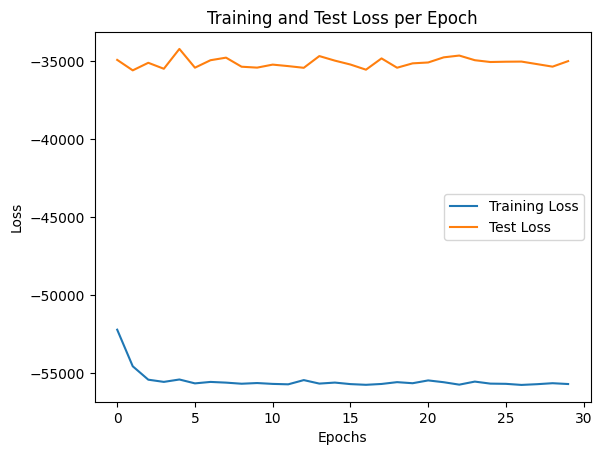

In [148]:
pred_features = ['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 
                             'PowerOutput_opt', 'DA_Price', 'UsableWindPower_opt', 'TotalPrecipitation', 'SolarDownwardRadiation', 'CloudCover', 'Solar_capacity_mwp', 
                             'Solar_installedcapacity_mwp']

# Dataset class for PyTorch DataLoader
class WindFarmDataset(Dataset):
    def __init__(self, data, features=pred_features):
        self.features = data[features].values
        self.actual = data['Wind_MW'].values + data['Solar_MW'].values
        self.dap = data['DA_Price'].values
        self.ssp = data['SS_Price'].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),
            'actual': torch.tensor(self.actual[idx], dtype=torch.float32),
            'dap': torch.tensor(self.dap[idx], dtype=torch.float32),
            'ssp': torch.tensor(self.ssp[idx], dtype=torch.float32)
        }

# Custom Loss Function based on Revenue Difference
class RevenueLoss(nn.Module):
    def __init__(self):
        super(RevenueLoss, self).__init__()

    def forward(self, prediction, actual, dap, ssp):
        trade = prediction
        optimal_revenue = (actual * dap)
        predicted_revenue = trade * dap + (actual - trade) * (ssp - 0.07 * (actual - trade))
        loss = torch.mean(torch.abs(optimal_revenue - predicted_revenue))
        return loss
    
class RevenueMaximizer(nn.Module):
    def __init__(self):
        super(RevenueMaximizer, self).__init__()

    def forward(self, prediction, actual, dap, ssp):
        trade = prediction
        revenue = trade * dap + (actual - trade) * (ssp - 0.07 * (actual - trade))
        # We want to maximize revenue, so we return negative revenue to simulate loss minimization
        return -torch.mean(revenue)  # Negative because optimizers minimize by default

# Define the Neural Network Model
class TradeForecastModel(nn.Module):
    def __init__(self, input_dim):
        super(TradeForecastModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Linear(32, 1)  # Output layer for Trade forecast
        )

    def forward(self, x):
        return self.network(x)

def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            features = batch['features'].to(device)
            actual = batch['actual'].to(device)
            dap = batch['dap'].to(device)
            ssp = batch['ssp'].to(device)
            predictions = model(features).squeeze()
            loss = criterion(predictions, actual, dap, ssp)
            total_loss += loss.item()
    return total_loss / len(loader)


# Initialize dataset and dataloader
train_data, test_data = train_test_split(data_combined, test_size=0.2, shuffle=False)
train_dataset = WindFarmDataset(train_data)
test_dataset = WindFarmDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_dataset.features.shape[1]
mlp_model = TradeForecastModel(input_dim=input_dim).to(device)
criterion = RevenueMaximizer().to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.003)

# Training Loop
epochs = 30
train_losses, test_losses = [], []
for epoch in range(epochs):
    mlp_model.train()
    total_train_loss = 0

    # Training step
    for batch in train_loader:
        features = batch['features'].to(device)
        actual = batch['actual'].to(device)
        dap = batch['dap'].to(device)
        ssp = batch['ssp'].to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = mlp_model(features).squeeze()
        
        # Calculate loss
        loss = criterion(predictions, actual, dap, ssp)
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation on test data
    avg_test_loss = evaluate_model(mlp_model, test_loader, criterion)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss per Epoch')
plt.show()

In [149]:
def compare_revenue(df, features=pred_features):
    features = torch.tensor(df[features].values, dtype=torch.float32)

    # Ensure model is in evaluation mode
    mlp_model.eval()
    with torch.no_grad():
        # Predict "submission"
        predictions = mlp_model(features.to(device)).cpu().numpy()  # Move features to device and get predictions
    df['submission'] = predictions

    df['submission'] = np.where(df['submission'] < 0, 0, df['submission'])
    df['submission'] = np.where(df['submission'] > 600, 600, df['submission'])

    # 2. Calculate revenue based on predicted "submission"
    df['revenue'] = (df['submission'] * df['DA_Price'] +
                    (df['Wind_MW'] - df['submission']) *
                    (df['SS_Price'] - 0.07 * (df['Wind_MW'] - df['submission'])))

    # 3. Calculate optimal revenue based on "Wind_MW" as the perfect submission
    df['opt_revenue'] = (df['Wind_MW'] * df['DA_Price'])

    # Display the calculated columns
    # df[['valid_time','PowerOutput_opt', 'Wind_MW', 'submission', 'revenue', 'opt_revenue', 'SS_Price', 'DA_Price']]

    # calculate the total revenue based for the test data
    print(df['revenue'].sum(), df.shape[0])
    print(df['opt_revenue'].sum())
    print(df['revenue'].sum() / df['opt_revenue'].sum())

    return df

compare_revenue(test_data)
compare_revenue(train_data)

216676868.926936 10168
246414774.940182
0.8793176828765038
1501658794.4671233 40670
1576074365.444268
0.9527842260436942


,WindSpeed:100_dwd,Temperature_avg,RelativeHumidity_avg,AirDensity,WindSpeed:100_dwd_lag1,WindSpeed:100_dwd_lag2,WindSpeed:100_dwd_lag3,PowerOutput_opt,DA_Price,SS_Price,Wind_MW,UsableWindPower_opt,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Solar_capacity_mwp,Solar_installedcapacity_mwp,Solar_MW,submission,revenue,opt_revenue
3,2.162314,14.571160,84.319755,1.220437,2.279211,2.396109,2.209602,0.000000,67.43,15.0,0.000,26.217597,0.000000,61.625058,0.170777,2130.510089,2228.208740,13.955679,0.000000,0.000000,0.00000
4,1.684080,14.509380,84.581793,1.220704,2.162314,2.279211,2.396109,0.000000,67.43,25.0,0.000,13.772537,0.000000,124.314157,0.170811,2130.510089,2228.208740,41.741401,3.536638,149.184025,0.00000
5,1.205846,14.447601,84.843835,1.220972,1.684080,2.162314,2.279211,0.000000,61.06,69.0,0.000,6.060571,0.000000,187.003256,0.170845,2130.510089,2228.208740,88.916788,56.657116,-674.559516,0.00000
6,1.037147,14.420489,84.614020,1.221116,1.205846,1.684080,2.162314,0.000000,61.06,46.4,0.000,5.123166,0.000000,254.232513,0.180609,2130.510089,2228.208740,136.653851,125.572906,737.099970,0.00000
7,0.868448,14.393377,84.384200,1.221259,1.037147,1.205846,1.684080,0.000000,62.37,22.5,0.000,4.287716,0.000000,321.461769,0.190372,2130.510089,2228.208740,197.922527,196.879761,5136.281247,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40668,4.014974,6.289609,68.068965,1.260137,3.802280,3.795240,3.788200,12.620374,128.67,110.0,17.382,129.152897,0.000000,0.001074,0.234161,2269.346019,2410.079685,0.000000,0.000000,1890.870625,2236.54194
40669,4.227668,6.319706,67.342078,1.260028,4.014974,3.802280,3.795240,13.339884,129.61,180.0,19.366,133.422986,0.000000,0.004297,0.261878,2269.346019,2410.079685,0.000000,0.000000,3459.627063,2510.02726
40670,4.359375,6.337820,67.405030,1.259939,4.227668,4.014974,3.802280,15.157052,129.61,117.6,19.185,144.207363,0.000000,0.002246,0.266915,2269.346019,2410.079685,0.000000,0.000000,2230.391504,2486.56785
40671,4.491083,6.355935,67.467985,1.259851,4.359375,4.227668,4.014974,17.069501,136.43,220.0,24.402,155.557207,0.000000,0.000195,0.271952,2269.346019,2410.079685,0.000000,0.000000,5326.757968,3329.16486


In [151]:
# save the mlp model
torch.save(mlp_model.state_dict(), os.path.join(os.getcwd(), 'models', 'mlp_trading_model_combined.pth'))

# Calculate the revenue on the actual competition data

## b) XGBoost

In [105]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assuming `data` is your DataFrame with necessary features and "Wind_MW" as the actual production
features = data[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 
                 'AirDensity', 'UsableWindPower_opt', 'WindSpeed:100_dwd_lag1', 
                 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 
                 'PowerOutput_opt', 'DA_Price', 'SS_Price']]
target = data['Wind_MW']  # Using Wind_MW as the "actual" production in training
da_price = data['DA_Price']
ss_price = data['SS_Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)
da_price_train, da_price_test = train_test_split(da_price, test_size=0.2, shuffle=False)
ss_price_train, ss_price_test = train_test_split(ss_price, test_size=0.2, shuffle=False)

# Convert data to DMatrix format without DA_Price and SS_Price
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define global variables for DA_Price and SS_Price
global_da_price = da_price_train.values
global_ss_price = ss_price_train.values

# Define custom objective function based on revenue loss
def revenue_loss(preds, dtrain):
    actual = dtrain.get_label()
    
    # Access global DA_Price and SS_Price
    da_price = global_da_price
    ss_price = global_ss_price
    
    # Calculate Revenue and the loss components
    residual = actual - preds
    gradient = -da_price + ss_price - 0.14 * residual  # Approximation for the derivative
    hessian = np.ones_like(gradient) * 0.14  # Approximate constant hessian for simplicity

    return gradient, hessian

# Set up model parameters without the 'objective' key
params = {
    'max_depth': 200,
    'learning_rate': 0.05,
    'tree_method': 'gpu_hist',
    'device': "cuda"
}

# Train the model with custom objective
xgb_model = xgb.train(params, dtrain, num_boost_round=200, obj=revenue_loss)
# eval_set is new dataframe of X_test and y_test
eval_set = X_test.copy()

eval_set['submission'] = xgb_model.predict(xgb.DMatrix(eval_set))

eval_set['Wind_MW'] = y_test
# Calculate revenue based on predicted "submission"
eval_set['revenue'] = (eval_set['submission'] * eval_set['DA_Price'] +
                   (eval_set['Wind_MW'] - eval_set['submission']) *
                   (eval_set['SS_Price'] - 0.07 * (eval_set['Wind_MW'] - eval_set['submission'])))

# Calculate optimal revenue based on "Wind_MW" as the perfect submission
eval_set['opt_revenue'] = (eval_set['Wind_MW'] * eval_set['DA_Price'])

# Display the calculated columns
print(eval_set[['submission', 'revenue', 'opt_revenue']])
# calculate the total revenue based for the test data
print(eval_set['revenue'].sum())
print(eval_set['opt_revenue'].sum())

eval_set = X_train.copy()

eval_set['submission'] = xgb_model.predict(xgb.DMatrix(eval_set))

eval_set['Wind_MW'] = y_train
# Calculate revenue based on predicted "submission"
eval_set['revenue'] = (eval_set['submission'] * eval_set['DA_Price'] +
                   (eval_set['Wind_MW'] - eval_set['submission']) *
                   (eval_set['SS_Price'] - 0.07 * (eval_set['Wind_MW'] - eval_set['submission'])))

# Calculate optimal revenue based on "Wind_MW" as the perfect submission
eval_set['opt_revenue'] = (eval_set['Wind_MW'] * eval_set['DA_Price'])

# Display the calculated columns
print(eval_set[['submission', 'revenue', 'opt_revenue']])
# calculate the total revenue based for the test data
print(eval_set['revenue'].sum())
print(eval_set['opt_revenue'].sum())


c:\VirtualEnvs\awp2\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


       submission       revenue  opt_revenue
46175  280.044617  15977.113924  15336.10422
46176  214.063950  15883.121688  15998.04864
46177  208.338577  15983.276893  16254.44604
46178  196.491791  15271.135661  15598.48017
46179  206.088013  14125.931908  14119.23747
...           ...           ...          ...
57713  574.536865  37358.442633  37378.88000
57714  653.594360  38741.714383  37585.19880
57715  644.549255  39168.864217  38462.72040
57716  729.228455  39316.593153  36291.94920
57717  643.272278  33770.979446  32753.26080

[11543 rows x 3 columns]
299251823.8341038
233980351.807789
       submission       revenue  opt_revenue
3       26.969320    322.953816    317.02671
4      -61.094208    358.009568     34.95470
5       57.294491    234.299268      0.00000
6       17.852974     21.784767      0.00000
7       16.104546     21.622314      0.00000
...           ...           ...          ...
46170 -285.015015  31868.404932  16778.00557
46171  411.789337  22043.889637  18737.

c:\VirtualEnvs\awp2\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


# ii. Modeling the residium 

# Training quantile Models

## GradientBoostingRegressor

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

def train_gbr_model_quantiles(dataset, residual = True, include_calculation_features = False, eval = False, shuffle = False, split = 0.2, name = None):
    # Define the features (X) and the target (y)
    X = dataset[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3']]
    if include_calculation_features and not residual:
        X['PowerOutput_opt'] = dataset['PowerOutput_opt']
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']
    if residual:
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']
    y = dataset['residual'] if residual else dataset['Wind_MW']

    # Split the data into training and test sets
    if split > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42, shuffle=shuffle)
    else:
        X_train, y_train = X, y

    # Define the quantiles we want to model
    quantiles = np.arange(0.1, 1.0, 0.1)

    # Dictionary to hold the best models for each quantile
    best_models = {}

    # Loop over each quantile and train a model
    for quantile in quantiles:
        print(f"Training model for {quantile * 100:.0f}% quantile...")
        
        # Initialize the Gradient Boosting Regressor with the quantile loss
        gbr = HistGradientBoostingRegressor(loss='quantile', quantile=quantile, random_state=42)
        
        # Define the parameter grid for hyperparameter tuning
        param_grid = {
            'learning_rate': [0.01, 0.1],  # Controls the step size in each boosting step
            'max_iter': [300, 500],  # Number of boosting rounds
            'max_depth': [3, 5, 7],  # Maximum depth of the trees
            'min_samples_leaf': [1, 5, 10],  # Minimum number of samples required to be at a leaf node
        }

        # Custom scoring function for quantile regression (Pinball loss)
        def pinball_loss(y_true, y_pred):
            delta = y_true - y_pred
            return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))
        
        pinball_scorer = make_scorer(pinball_loss, greater_is_better=False)
        
        # Initialize GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring=pinball_scorer)
        
        # Fit the model to the training data
        grid_search.fit(X_train, y_train)
        
        # Store the best model for this quantiles
        best_models[quantile] = grid_search.best_estimator_
        
        print(f"Best parameters for {quantile * 100:.0f}% quantile: {grid_search.best_params_}")

    if eval and split > 0:
        # Loop over each quantile to evaluate the models
        for quantile, model in best_models.items():
            # Predict the residuals for the test set
            y_pred = model.predict(X_test)
            
            # Calculate the evaluation metrics
            me = np.mean(y_test - y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            pinball = pinball_loss(y_test, y_pred)
            
            print(f"Evaluation for {quantile * 100:.0f}% quantile:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")

            # compare to training data
            y_pred_train = model.predict(X_train)
            me = np.mean(y_train - y_pred_train)
            mae = mean_absolute_error(y_train, y_pred_train)
            rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            pinball = pinball_loss(y_train, y_pred_train)

            print(f"\nTraining data:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")
            print("-" * 40)

    for quantile, model in best_models.items():
        joblib.dump(model, os.path.join(os.getcwd(), 'models', f'gbr_quantile_{quantile:.1f}{"_" + name if name is not None else ""}_res-{residual}_calc-{include_calculation_features}.pkl'))
    
    return best_models



In [43]:
best_models_gbr = train_gbr_model_quantiles(df_latest, eval=True, )

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 1}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01,

# XGBoost

In [44]:
def train_xgb_model_quantiles(dataset, residual = True, include_calculation_features = False, eval = False, shuffle = False, split = 0.2):
    # Define the features (X) and the target (y)
    X = dataset[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3']]
    if include_calculation_features and not residual:
        X['PowerOutput_opt'] = dataset['PowerOutput_opt']
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']
    if residual:
        X['UsableWindPower_opt'] = dataset['UsableWindPower_opt']

    y = dataset['residual'] if residual else dataset['Wind_MW']

    # Split the data into training and test sets
    if split > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42, shuffle=shuffle)
    else:
        X_train, y_train = X, y

    # Define the quantiles we want to model
    quantiles = np.arange(0.1, 1.0, 0.1)

    # Dictionary to hold the best models for each quantile
    best_models = {}

    # Loop over each quantile and train a model
    for quantile in quantiles:
        print(f"Training model for {quantile * 100:.0f}% quantile...")
        
        # Initialize the XGBoost Regressor with the quantile loss and GPU support
        xg_reg = xgb.XGBRegressor(objective='reg:quantile', alpha=quantile, tree_method='gpu_hist', random_state=42, verbosity=1)
        
        # Define the parameter grid for hyperparameter tuning
        param_grid = {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [300, 500],
            'max_depth': [3, 5, 7],
            'subsample': [0.7],
            'colsample_bytree': [0.7, 1.0]
        }

        # Custom scoring function for quantile regression (Pinball loss)
        def pinball_loss(y_true, y_pred):
            delta = y_true - y_pred
            return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))
        
        pinball_scorer = make_scorer(pinball_loss, greater_is_better=False)
        
        # Initialize GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=pinball_scorer)
        
        # Fit the model to the training data
        grid_search.fit(X_train, y_train)
        
        # Store the best model for this quantile
        best_models[quantile] = grid_search.best_estimator_
        
        print(f"Best parameters for {quantile * 100:.0f}% quantile: {grid_search.best_params_}")
    
    if eval:
        # Loop over each quantile to evaluate the models
        for quantile, model in best_models.items():
            # Predict the residuals for the test set
            y_pred = model.predict(X_test)
            
            # Calculate the evaluation metrics
            me = np.mean(y_test - y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            pinball = pinball_loss(y_test, y_pred)
            
            print(f"Evaluation for {quantile * 100:.0f}% quantile:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")
            print("-" * 40)

            # compare to training data
            y_pred_train = model.predict(X_train)
            me = np.mean(y_train - y_pred_train)
            mae = mean_absolute_error(y_train, y_pred_train)
            rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            pinball = pinball_loss(y_train, y_pred_train)

            print(f"\nTraining data:")
            print(f"Mean Error (ME): {me:.3f}")
            print(f"Mean Absolute Error (MAE): {mae:.3f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
            print(f"Pinball Loss: {pinball:.3f}")
            print("-" * 40)
    
    for quantile, model in best_models.items():
        joblib.dump(model, os.path.join(os.getcwd(), 'models', f'xgboost_quantile_{quantile:.1f}_res-{residual}_calc-{include_calculation_features}.pkl'))
    
    return best_models

In [ ]:
best_models_xgb = train_xgb_model_quantiles(df_latest)

# Exploring the performance for sample dates

In [45]:
import joblib
import os
import plotly.graph_objs as go
import numpy as np
from IPython.display import display

def create_forecast_for_dates(start_day, end_day = None, all = False, gbr = False, xgb = False, show_data = False, res = True, calc = False):
    if all == True:
        gbr = True
        xgb = True
    if end_day is None:
        end_day = start_day
    
    # Define the quantiles
    quantiles = np.arange(0.1, 1.0, 0.1)

    # Now, make predictions using the loaded models for your sample data
    start_date = pd.to_datetime(np.datetime64(start_day)).tz_localize('UTC')
    end_date = pd.to_datetime(np.datetime64(end_day)).tz_localize('UTC')
    sample_data = df_latest[((df_latest['valid_time'].dt.date >= start_date.date()) & (df_latest['valid_time'].dt.date <= end_date.date()))]

    # Prepare the feature data for prediction from the sample_data
    X_sample = sample_data[['WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3']]
    if calc and not res:
        X_sample['PowerOutput_opt'] = sample_data['PowerOutput_opt']
        X_sample['UsableWindPower_opt'] = sample_data['UsableWindPower_opt']
    
    if res:
        # Also use the calculated UseableWindPower when predicting the residuals
        X_sample['UsableWindPower_opt'] = sample_data['UsableWindPower_opt']

    # Real data (Wind_MW)
    y_real = sample_data['Wind_MW'].values

    # Add custom data for hover
    custom_data = sample_data[['WindSpeed:100_dwd', 'PowerOutput_opt', 'WindSpeed:100_ncep']]

    # Plot GBR quantile predictions
    if gbr:
        best_models_gbr = {}
        for quantile in quantiles:
            model_path_gbr = os.path.join(os.getcwd(), 'models', f'gbr_quantile_{quantile:.1f}_boa_v2_res-{res}_calc-{calc}.pkl')
            best_models_gbr[quantile] = joblib.load(model_path_gbr)
        gbr_predictions = {}
        for quantile in quantiles:
            gbr_predictions[quantile] = best_models_gbr[quantile].predict(X_sample) + sample_data['PowerOutput_opt'] if res else best_models_gbr[quantile].predict(X_sample)

        fig1 = go.Figure()
        fig1.add_trace(go.Scatter(
            x=sample_data['valid_time'], 
            y=y_real, 
            mode='lines+markers', 
            name='Real Data (Wind_MW)', 
            line=dict(color='black'),
            customdata=custom_data,  # Add custom data to hover
            hovertemplate='Wind MW: %{y:.3f}<br>PowerOutput_opt: %{customdata[1]:.3f}<br>WindSpeed:100_dwd: %{customdata[0]:.3f}<br>WindSpeed:100_ncpe: %{customdata[2]:.3f}<extra></extra>'
        ))
        for quantile in quantiles:
            fig1.add_trace(go.Scatter(
                x=sample_data['valid_time'],
                y=gbr_predictions[quantile],
                mode='lines',
                name=f'GBR {int(quantile * 100)}th Percentile',
                line=dict(dash='dash')
            ))

        fig1.update_layout(
            title=f"Quantile Predictions (GradientBoosting) on {start_date.date()} to {end_date.date()}",
            xaxis_title="Valid Time",
            yaxis_title="Power Output (MW)",
            hovermode="x unified",
            legend_title="Models"
        )

        fig1.show()
    
    # Plot XGB quantile predictions
    if xgb:
        best_models_xgb = {}
        for quantile in quantiles:
            model_path_xgb = os.path.join(os.getcwd(), 'models', f'xgboost_quantile_{quantile:.1f}_res-{res}_calc-{calc}.pkl')
            best_models_xgb[quantile] = joblib.load(model_path_xgb)

        xgb_predictions = {}
        for quantile in quantiles:
            xgb_predictions[quantile] = best_models_xgb[quantile].predict(X_sample) + sample_data['PowerOutput']

        fig2 = go.Figure()
        fig2.add_trace(go.Scatter(
            x=sample_data['valid_time'], 
            y=y_real, 
            mode='lines+markers', 
            name='Real Data (Wind_MW)', 
            line=dict(color='black'),
            customdata=custom_data,  # Add custom data to hover
            hovertemplate='Wind MW: %{y:.3f}<br>PowerOutput_opt: %{customdata[1]:.3f}<br>WindSpeed:100_dwd: %{customdata[0]:.3f}<extra></extra>'
        ))
        for quantile in quantiles:
            fig2.add_trace(go.Scatter(
                x=sample_data['valid_time'],
                y=xgb_predictions[quantile],
                mode='lines',
                name=f'XGB {int(quantile * 100)}th Percentile',
                line=dict(dash='dash')
            ))

        fig2.update_layout(
            title=f"Quantile Predictions (XGBoost) from {start_date.date()} to {end_date.date()}",
            xaxis_title="Valid Time",
            yaxis_title="Power Output (MW)",
            hovermode="x unified",
            legend_title="Models"
        )

        fig2.show()
    if show_data:
        X_sample['PowerOutput_opt'] = sample_data['PowerOutput_opt']
        X_sample['timestamp'] = sample_data['valid_time']
        pd.set_option('display.max_rows', None)
        display(X_sample)
        pd.set_option('display.max_rows', 10)


In [46]:
create_forecast_for_dates('2023-11-01', gbr=True)

In [47]:
start_day = df_latest['valid_time'].dt.date.min()

In [49]:
create_forecast_for_dates(start_day, start_day + pd.DateOffset(days=3), gbr=True)
start_day = start_day + pd.DateOffset(days=4)

In [806]:
start_day = df_latest['valid_time'].dt.date.min()

In [807]:
create_forecast_for_dates(start_day, start_day + pd.DateOffset(days=3), gbr=True)
start_day = start_day + pd.DateOffset(days=4)

## When looking through the ouputs, it seems wise to delete the upper limit for power generation from entirely to get rid o the extreme forecasts

In [50]:
df_latest = calculate_wind_generation(df_latest, efficiency=efficiency, limiter=limiter, add_opt = True, maximum_wind_speed_for_operation = np.inf)
df_latest['residual'] = df_latest['Wind_MW'] - df_latest['PowerOutput_opt']

# add three lag features for WindSpeed:100_dwd
df_latest['WindSpeed:100_dwd_lag1'] = df_latest['WindSpeed:100_dwd'].shift(1)
df_latest['WindSpeed:100_dwd_lag2'] = df_latest['WindSpeed:100_dwd'].shift(2)
df_latest['WindSpeed:100_dwd_lag3'] = df_latest['WindSpeed:100_dwd'].shift(3)

df_latest = df_latest.dropna()

In [51]:
df_training_set = df_latest[['valid_time', 'reference_time', 'WindSpeed:100_dwd', 'Temperature_avg', 'RelativeHumidity_avg', 'AirDensity', 'UsableWindPower_opt', 'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2', 'WindSpeed:100_dwd_lag3', 'residual', 'PowerOutput_opt', 'Wind_MW']]

In [53]:
df_problematic_datapoints = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'wind_problematic_datapoints.csv'))

# Convert 'start_date' and 'end_date' to datetime format
df_problematic_datapoints['start_time'] = pd.to_datetime(df_problematic_datapoints['start_time'])
df_problematic_datapoints['end_time'] = pd.to_datetime(df_problematic_datapoints['end_time'])

print(df_training_set.shape)

# Ensure the 'valid_time' column in df_training_set is in datetime format
df_training_set['valid_time'] = pd.to_datetime(df_training_set['valid_time'])

# Loop over each date range in df_problematic_datapoints and filter out the rows in df_training_set
for idx, row in df_problematic_datapoints.iterrows():
    start_date = row['start_time']
    end_date = row['end_time']
    
    # Filter out rows that fall within the current date range
    df_training_set = df_training_set[~((df_training_set['valid_time'] >= start_date) & (df_training_set['valid_time'] <= end_date))]

print(df_training_set.shape)
df_training_set.to_csv(os.path.join(os.getcwd(), '..', 'data', 'wind_training_set.csv'), index=False)

(57805, 13)
(57028, 13)


# Re-training of the models

### GBR Models

In [55]:
best_models_gbr = train_gbr_model_quantiles(df_training_set, residual = True, include_calculation_features = False, eval=True)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 1}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 5}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 5}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01, 'ma

In [751]:
best_models_gbr = train_gbr_model_quantiles(df_training_set, residual = False, include_calculation_features = False, eval=True)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 500, 'min_samples_leaf': 5}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 10}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 1}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01, 'm

In [753]:
best_models_gbr = train_gbr_model_quantiles(df_training_set, residual = False, include_calculation_features = True, eval=True)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 1}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 10}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01

# The best model is the RTCF model. Lets retrain it on the full dataset to obtain the model to use for the actual forecast

In [57]:
train_gbr_model_quantiles(df_training_set, residual = True, include_calculation_features = False, eval=False, split = 0)

Training model for 10% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 10% quantile: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500, 'min_samples_leaf': 1}
Training model for 20% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 20% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 5}
Training model for 30% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 30% quantile: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 10}
Training model for 40% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 40% quantile: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 1}
Training model for 50% quantile...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 50% quantile: {'learning_rate': 0.01, 'm

{0.1: HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=5,
                               max_iter=500, min_samples_leaf=1, quantile=0.1,
                               random_state=42),
 0.2: HistGradientBoostingRegressor(loss='quantile', max_depth=3, max_iter=500,
                               min_samples_leaf=5, quantile=0.2,
                               random_state=42),
 0.30000000000000004: HistGradientBoostingRegressor(loss='quantile', max_depth=3, max_iter=300,
                               min_samples_leaf=10, quantile=0.30000000000000004,
                               random_state=42),
 0.4: HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=3,
                               max_iter=500, min_samples_leaf=1, quantile=0.4,
                               random_state=42),
 0.5: HistGradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=3,
                               max_iter=300, min_samples_leaf=10,

In [759]:
df_training_set.columns

Index(['valid_time', 'reference_time', 'WindSpeed:100_dwd', 'Temperature_avg',
       'RelativeHumidity_avg', 'AirDensity', 'UsableWindPower_opt',
       'WindSpeed:100_dwd_lag1', 'WindSpeed:100_dwd_lag2',
       'WindSpeed:100_dwd_lag3', 'residual', 'PowerOutput_opt', 'Wind_MW'],
      dtype='object')

In [760]:
tmp = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'wind2.csv'))
tmp.columns

Index(['reference_time', 'valid_time', 'RelativeHumidity_dwd',
       'Temperature_dwd', 'WindDirection_dwd', 'WindDirection:100_dwd',
       'WindSpeed^3_dwd', 'WindSpeed:100^3_dwd', 'WindSpeed_dwd',
       'WindSpeed:100_dwd', 'WindSpeed^3:100_dwd', 'RelativeHumidity_ncep',
       'Temperature_ncep', 'WindDirection_ncep', 'WindDirection:100_ncep',
       'WindSpeed^3_ncep', 'WindSpeed:100^3_ncep', 'WindSpeed_ncep',
       'WindSpeed:100_ncep', 'WindSpeed^3:100_ncep', 'dtm', 'MIP', 'Wind_MW',
       'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit'],
      dtype='object')